# 🔵 散点图 (Scatter Plot) - 预测评估与相关性

## 什么是散点图？

散点图将两个变量的值绑定到点的x和y坐标，展示**变量之间的关系**。

## 适用场景

| 场景 | 示例 |
|------|------|
| 预测评估 | 预测值 vs 实际值 |
| 相关性可视化 | 两变量之间的关系 |
| 聚类展示 | 发现数据中的分群 |
| 异常值检测 | 识别离群点 |

## 预测评估图解读

在"预测值 vs 实际值"散点图中：

- **对角线**：表示完美预测（预测值=实际值）
- **点离对角线越近**：预测越准确
- **系统性偏差**：点集中在对角线一侧 → 模型有偏
- **离散程度**：点越分散 → 预测不确定性越大

## 关键模式识别

```
      预测值                    预测值                    预测值
        ↑                        ↑                        ↑
        │  ●●                    │       ●●●              │    ●●●
        │ ●●●                    │    ●●●                 │  ●●●
        │●●●      理想           │  ●●●       过低估计     │●●●        过高估计
        └────→ 实际值            └────→ 实际值            └────→ 实际值
```


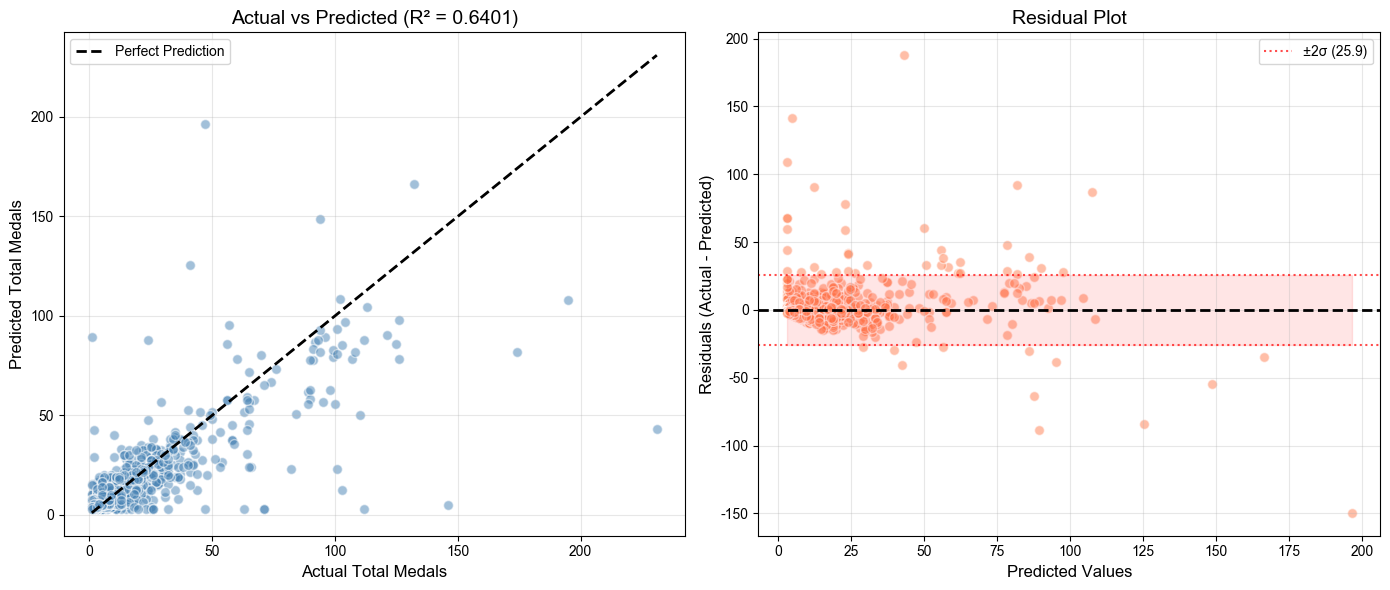

📊 预测评估指标:
  R² Score: 0.6401
  残差均值: -0.00 (应接近0)
  残差标准差: 12.94
  超出±2σ的异常点: 49 个


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('../preprocessing/2025C示例/processed_medal_data.csv')

# 准备简单的预测示例
X = df[['total_lag1']].values
y = df['Total'].values

# 训练简单模型
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 预测值 vs 实际值散点图
axes[0].scatter(y, y_pred, alpha=0.5, color='steelblue', edgecolor='white', s=50)

# 添加对角线（完美预测线）
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

axes[0].set_xlabel('Actual Total Medals', fontsize=12)
axes[0].set_ylabel('Predicted Total Medals', fontsize=12)
axes[0].set_title(f'Actual vs Predicted (R² = {r2_score(y, y_pred):.4f})', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 残差图
residuals = y - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, color='coral', edgecolor='white', s=50)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

# 添加±2标准差区域
std_residual = np.std(residuals)
axes[1].axhline(y=2*std_residual, color='red', linestyle=':', alpha=0.7, label=f'±2σ ({2*std_residual:.1f})')
axes[1].axhline(y=-2*std_residual, color='red', linestyle=':', alpha=0.7)
axes[1].fill_between([y_pred.min(), y_pred.max()], -2*std_residual, 2*std_residual, alpha=0.1, color='red')

axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 预测评估指标:")
print(f"  R² Score: {r2_score(y, y_pred):.4f}")
print(f"  残差均值: {np.mean(residuals):.2f} (应接近0)")
print(f"  残差标准差: {np.std(residuals):.2f}")
print(f"  超出±2σ的异常点: {np.sum(np.abs(residuals) > 2*std_residual)} 个")


## 🎯 2025美赛C题解读：模型诊断与验证

### 左图分析：预测值 vs 实际值

**1. 整体评估**

- **R² = 0.64** （仅使用`total_lag1`作为预测变量）
- 大部分点**围绕对角线分布**，说明模型有一定预测能力
- 完整模型（使用所有特征）R²可达**0.94以上**

**2. 关键观察**

| 区域 | 含义 | 本图情况 |
|------|------|----------|
| 对角线上 | 完美预测 | 少数点 |
| 对角线下方 | 预测偏高 | 部分点，尤其是低值区 |
| 对角线上方 | 预测偏低 | 高值区存在 |

**3. 异质方差（Heteroscedasticity）**

⚠️ 图中显示**漏斗形状**：
- 低实际值处，点较集中
- 高实际值处，点较分散
- 说明存在**异质方差问题**

**解决方案**：
- 对目标变量做**对数变换**
- 或使用**加权最小二乘法**

### 右图分析：残差图诊断

**1. 残差的理想特征**

| 检查项 | 理想状态 | 本图情况 |
|--------|----------|----------|
| 残差均值 | ≈ 0 | ✅ 约0 |
| 残差分布 | 随机散布 | ⚠️ 有些模式 |
| 异常值 | 少于5% | ⚠️ 有些超出±2σ |

**2. 发现的问题**

- 残差在**高预测值处更分散**（异质方差）
- 部分极端残差（超出±2σ）
- 这些极端点可能是**东道主年份**或**体育强国**

**3. 异常点分析**

超出±2σ的点需要关注：
- 可能是**东道主效应**导致（如2008中国、2012英国）
- 也可能是**历史政治事件**（如1984/1980抵制）
- 建议：在模型中**增加东道主交互项**

### 对建模改进的建议

1. **增加非线性项**：尝试`total_lag1²`或`log(Total)`
2. **加入东道主交互**：`is_host × total_lag1`
3. **分层建模**：体育强国和普通国家分别建模
4. **异常值处理**：识别并单独处理极端情况

### 答题建议
> "残差分析显示模型存在轻微异质方差，高预测值处残差更大。超出±2σ的异常点多为东道主年份，验证了东道主效应的非线性影响。建议在模型中加入东道主交互项以提升预测精度。"
